In [1]:
import pandas as pd
import os
import random
import shutil
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import logging
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split

/tmp/ipykernel_71960/1281039887.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-21 18:24:37.912764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 18:24:37.912821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 18:24:37.914977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Set GPU memory limit to 14 GB
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=14*1024)]
        )
    except RuntimeError as e:
        print(e)

# Function to clear VRAM
def clear_memory():
    tf.keras.backend.clear_session()

In [3]:
tf.config.run_functions_eagerly(True) #fix for https://github.com/tensorflow/tensorflow/issues/59578

Finding Number of faces in FAKE and REAL labelled folders

In [4]:
face_path = "faces"
fake_images_dir = os.path.join(face_path, "FAKE")
real_images_dir = os.path.join(face_path,"REAL")

In [3]:

# print("No. of Deep-Faked Faces",len(os.listdir(fake_images_dir)))
# print("No. of Real Faces",len(os.listdir(real_images_dir)))

No. of Deep-Faked Faces 9810
No. of Real Faces 1201


There are 9x more fake images than real images, so we need to balance the dataset. We will follow a mixed approach to balance the dataset.

1. Remove the 3rd frame from the fake videos to reduce the number of fake images. (approximately 3x reduction in fake images)
2. Randomly select n number of fake images to balance the dataset. (where n is variable and model is trained on different values of n to find the best value)

We are moving all the unused images to a separate folder called `unused_images` for future use.

In [5]:
os.listdir(fake_images_dir)[:10]

['yhlarojulr.mp4_1.jpg',
 'pgrghbkdje.mp4_1.jpg',
 'zyxpalvtsh.mp4_0.jpg',
 'uziohtecjc.mp4_1.jpg',
 'ijfurmuiih.mp4_1.jpg',
 'kqcxyyewep.mp4_0.jpg',
 'kjnffimpfp.mp4_1.jpg',
 'uxnaaimitn.mp4_0.jpg',
 'plkdwbceoh.mp4_0.jpg',
 'bbkprckncv.mp4_1.jpg']

In [6]:
unused_folder = os.path.join(face_path, "unused_images")

if not os.path.exists(unused_folder):
    os.mkdir(unused_folder)

fake_images = glob.glob(os.path.join(fake_images_dir, "*_2.j*"))

for file_path in fake_images:
    filename = os.path.basename(file_path)
    dest_path = os.path.join(unused_folder, filename)
    shutil.move(file_path, dest_path)

print(len(os.listdir(fake_images_dir)))

6745


In [7]:
def n_random_files(n,src_dir):
  files = list(map(lambda x : os.path.join(src_dir, x),os.listdir(src_dir)))
  sampled_files = random.sample(files,n)
  return sampled_files

fake_1000 = n_random_files(1000,fake_images_dir)
print(len(fake_1000), fake_1000[:5])

1000 ['faces/FAKE/mdydgtvghc.mp4_1.jpg', 'faces/FAKE/meehftqexr.mp4_0.jpg', 'faces/FAKE/eyjejjgdyd.mp4_0.jpg', 'faces/FAKE/qgnhqmtbko.mp4_1.jpg', 'faces/FAKE/dpqxzvyccv.mp4_0.jpg']


Loading the Images and the Labels

In [8]:
a = cv2.imread(fake_1000[0])
print(a.shape)

(224, 224, 3)


In [9]:
def load_dataset(fake_files, real_files):
  images = []
  labels = []

  for file in fake_files:
    image = cv2.imread(file)
    images.append(image)
    labels.append(1)
  
  for file in real_files:
    image = cv2.imread(file)
    images.append(image)
    labels.append(0)
  
  return np.array(images), np.array(labels)

In [8]:
fake_files = n_random_files(100,fake_images_dir)
real_files = n_random_files(100,real_images_dir)

images, labels = load_dataset(fake_files, real_files)

print(images.shape, labels.shape)

(200, 224, 224, 3) (200,)


Train the model on the dataset

In [9]:
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)

In [10]:
train_images = tf.keras.applications.efficientnet.preprocess_input(train_images)
val_images = tf.keras.applications.efficientnet.preprocess_input(val_images)

In [12]:

base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

2024-02-21 14:02:11.938941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14781 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


In [ ]:
batch_size=12
epochs=5

In [13]:
history = model.fit(train_images, train_labels, epochs=epochs,batch_size=batch_size, validation_data=(val_images, val_labels))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(val_images, val_labels)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/5


/home/psg/.local/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-02-21 14:02:19.675955: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-21 14:02:19.744457: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-21 14:02:19.931192: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. pt

5/5 [==============================] - 8s 611ms/step - loss: 0.7337 - accuracy: 0.3929 - val_loss: 0.6393 - val_accuracy: 0.6167
Epoch 2/5
5/5 [==============================] - 3s 545ms/step - loss: 0.6681 - accuracy: 0.6143 - val_loss: 0.5754 - val_accuracy: 0.8167
Epoch 3/5
5/5 [==============================] - 3s 594ms/step - loss: 0.6143 - accuracy: 0.6857 - val_loss: 0.5334 - val_accuracy: 0.8333
Epoch 4/5
5/5 [==============================] - 3s 527ms/step - loss: 0.5935 - accuracy: 0.7214 - val_loss: 0.4997 - val_accuracy: 0.8667
Epoch 5/5
2/2 [==============================] - 0s 171ms/step - loss: 0.4785 - accuracy: 0.8333
Test Accuracy: 83.33%


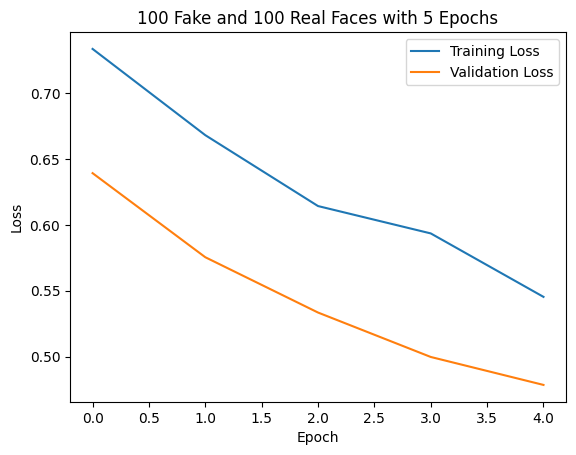

In [15]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('100 Fake and 100 Real Faces with 5 Epochs') 
plt.show()

Iterating through different values of n to find the best value

In [13]:
if not os.path.exists('logs'):
    os.mkdir('logs')

now = datetime.now()
log_name = f"log-{now.strftime('%Y-%m-%d_%H:%M')}.log"
log_file_path = os.path.join('logs', log_name)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s',handlers=[
        logging.StreamHandler(),  # Log to the console
        logging.FileHandler(log_file_path)  # Log to a file
    ])

In [14]:
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [15]:


def train_and_evaluate_model(n, fake_images_dir, real_images_dir, epochs=30, batch_size=32):
    logging.info(f"Training model for {n} fake and {len(os.listdir(real_images_dir))} real faces.")
    now = datetime.now()
    date_time = now.strftime("%m-%d_%H:%M")

    fake_files = n_random_files(n, fake_images_dir)
    real_files = n_random_files(len(os.listdir(real_images_dir)), real_images_dir)
    images, labels = load_dataset(fake_files, real_files)
    logging.info(f"Loaded {len(images)} images and {len(labels)} labels.")
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels, test_size=0.3, random_state=42
    )

    train_images = tf.keras.applications.efficientnet.preprocess_input(train_images)
    val_images = tf.keras.applications.efficientnet.preprocess_input(val_images)
    logging.info("Preprocessed images.")

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')  
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images, val_labels))
    logging.info("Model trained.")
    
    test_loss, test_accuracy = model.evaluate(val_images, val_labels)

    # Logging model evaluation metrics
    logging.info(f"Model Evaluation for {n} fake and {len(os.listdir(real_images_dir))} real faces:")
    logging.info(f"Test Loss: {test_loss}")
    logging.info(f"Test Accuracy: {test_accuracy}")

    # Plotting accuracies
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{n} Fake and {len(os.listdir(real_images_dir))} Real Faces with {epochs} Epochs')
    plt.legend()

    accuracies_plot_path = f'plots/accuracies/{n}_fake_{len(os.listdir(real_images_dir))}_real_faces_{epochs}_epochs_{date_time}.png'
    os.makedirs(os.path.dirname(accuracies_plot_path), exist_ok=True)
    plt.savefig(accuracies_plot_path)
    plt.close()

    # Display confusion matrix
    val_predictions = model.predict(val_images)
    val_predictions = (val_predictions > 0.5).astype(int)

    cm = confusion_matrix(val_labels, val_predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'{n} Fake and {len(os.listdir(real_images_dir))} Real Faces')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    confusion_matrix_plot_path = f'plots/confusion_matrices/{n}_fake_{len(os.listdir(real_images_dir))}_real_faces_{epochs}_epochs_{date_time}.png'
    os.makedirs(os.path.dirname(confusion_matrix_plot_path), exist_ok=True)
    plt.savefig(confusion_matrix_plot_path)
    plt.close()

    # Display loss graph
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{n} Fake and {len(os.listdir(real_images_dir))} Real Faces with {epochs} Epochs')
    losses_plot_path = f'plots/losses/{n}_fake_{len(os.listdir(real_images_dir))}_real_faces_{epochs}_epochs_{date_time}.png'
    os.makedirs(os.path.dirname(losses_plot_path), exist_ok=True)
    plt.savefig(losses_plot_path)
    plt.close()

    clear_memory()

In [ ]:
def create_base_model(base='b0', regularization=False, reg=0):
    base_model = None
    if base == 'b0':
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
    elif base == 'b2':
        base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet')

    if not regularization:
        model = tf.keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(1, activation='sigmoid')  
        ])
    else:
        model = tf.keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(reg))  
        ])
        logging.info(f"Regularization term of {reg} added")

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, train_generator, val_generator, epochs=30):
    history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)
    logging.info("Model trained.")
    return history

def evaluate_model(model, val_images, val_labels):
    test_loss, test_accuracy = model.evaluate(val_images, val_labels)
    logging.info(f"Test Loss: {test_loss}")
    logging.info(f"Test Accuracy: {test_accuracy}")

def plot_metrics(history, title, output_dir, n, real_images_dir, epochs):
    # Plotting accuracies
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{n} Fake and {len(os.listdir(real_images_dir))} Real Faces with {epochs} Epochs - {title}')
    plt.legend()

    accuracies_plot_path = os.path.join(output_dir, f'accuracies_{title}.png')
    os.makedirs(os.path.dirname(accuracies_plot_path), exist_ok=True)
    plt.savefig(accuracies_plot_path)
    plt.close()

    # Display confusion matrix
    val_predictions = model.predict(val_images)
    val_predictions = (val_predictions > 0.5).astype(int)

    cm = confusion_matrix(val_labels, val_predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'{n} Fake and {len(os.listdir(real_images_dir))} Real Faces - {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    confusion_matrix_plot_path = os.path.join(output_dir, f'confusion_matrix_{title}.png')
    os.makedirs(os.path.dirname(confusion_matrix_plot_path), exist_ok=True)
    plt.savefig(confusion_matrix_plot_path)
    plt.close()

    # Display loss graph
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{n} Fake and {len(os.listdir(real_images_dir))} Real Faces with {epochs} Epochs - {title}')
    losses_plot_path = os.path.join(output_dir, f'losses_{title}.png')
    os.makedirs(os.path.dirname(losses_plot_path), exist_ok=True)
    plt.savefig(losses_plot_path)
    plt.close()

def train_and_evaluate_model(n, fake_images_dir, real_images_dir, epochs=30, batch_size=16, regularization=False, reg=0, base='b0'):
    logging.info(f"Training model for {n} fake and {len(os.listdir(real_images_dir))} real faces of epochs {epochs}")
    now = datetime.now()
    date_time = now.strftime("%m-%d_%H:%M")

    fake_files = n_random_files(n, fake_images_dir)
    real_files = n_random_files(len(os.listdir(real_images_dir)), real_images_dir)
    images, labels = load_dataset(fake_files, real_files)

    datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

    logging.info(f"Loaded {len(images)} images and {len(labels)} labels.")
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels, test_size=0.3, random_state=42
    )

    train_generator = datagen.flow(x=train_images, y=train_labels, batch_size=batch_size, shuffle=True)
    val_generator = datagen.flow(x=val_images, y=val_labels, batch_size=batch_size, shuffle=False)
    logging.info("Preprocessed images.")

    model = create_base_model(base=base, regularization=regularization, reg=reg)

    history = train_model(model, train_generator, val_generator, epochs=epochs)
    
    evaluate_model(model, val_images, val_labels)

    title = f'Final-{n}_fake_{len(os.listdir(real_images_dir))}_real_faces_{epochs}_epochs_{date_time}'
    output_dir = 'plots'
    plot_metrics(history, title, output_dir, n, real_images_dir, epochs)

    model.save("Deepfake2d.h5")
    clear_memory()
    del model
    del history
    del train_generator
    del val_generator
    del images
    del labels
    del train_images
    del val_images
    del train_labels
    del val_labels

    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        memory_info = get_gpu_memory_usage()
        logging.info(f"Before Cleaning GPU {gpu.name}, memory usage: {memory_info['free']} / {memory_info['total']} MB")

    clear_memory()

In [16]:
# List of values for 'n'
n_list = [3000, 4000, 5000, 6000]
# n_list = [1000]
epochs = 30

# Train and evaluate models for different 'n' values
for n in n_list:
    train_and_evaluate_model(n, fake_images_dir, real_images_dir, epochs=epochs)

2024-02-21 18:32:36,509 - INFO - Training model for 3000 fake and 1201 real faces.
2024-02-21 18:32:43,464 - INFO - Loaded 4201 images and 4201 labels.
2024-02-21 18:32:43,724 - INFO - Preprocessed images.


Epoch 1/30
92/92 [==============================] - 47s 512ms/step - loss: 0.5128 - accuracy: 0.7310 - val_loss: 0.4738 - val_accuracy: 0.7708
Epoch 2/30
92/92 [==============================] - 46s 496ms/step - loss: 0.4479 - accuracy: 0.7854 - val_loss: 0.4418 - val_accuracy: 0.7891
Epoch 3/30
92/92 [==============================] - 45s 485ms/step - loss: 0.4243 - accuracy: 0.7983 - val_loss: 0.4190 - val_accuracy: 0.8002
Epoch 4/30
92/92 [==============================] - ETA: 0s - loss: 0.4023 - accuracy: 0.8160

In [ ]:


def train_and_evaluate_model(n, fake_images_dir, real_images_dir, epochs=30, batch_size=16,regularization=False,reg=0):
    logging.info(f"Training model for {n} fake and {len(os.listdir(real_images_dir))} real faces of epochs {epochs}")
    now = datetime.now()
    date_time = now.strftime("%m-%d_%H:%M")

    fake_files = n_random_files(n, fake_images_dir)
    real_files = n_random_files(len(os.listdir(real_images_dir)), real_images_dir)
    images, labels = load_dataset(fake_files, real_files)

    datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

    logging.info(f"Loaded {len(images)} images and {len(labels)} labels.")
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels, test_size=0.3, random_state=42
    )

    train_generator = datagen.flow(x=train_images, y=train_labels, batch_size=batch_size, shuffle=True)
    val_generator = datagen.flow(x=val_images, y=val_labels, batch_size=batch_size, shuffle=False)
    logging.info("Preprocessed images.")

    if not regularization:
        model = tf.keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(1, activation='sigmoid')  
        ])
    else:
        model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(reg))  
        ])
        logging.info(f"REgularization term of {reg} added")

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)
    logging.info("Model trained.")
    
    test_loss, test_accuracy = model.evaluate(val_images, val_labels)

    # Logging model evaluation metrics
    logging.info(f"Model Evaluation for {n} fake and {len(os.listdir(real_images_dir))} real faces:")
    logging.info(f"Test Loss: {test_loss}")
    logging.info(f"Test Accuracy: {test_accuracy}")

    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        memory_info = get_gpu_memory_usage()
        logging.info(f"Before Cleaning GPU {gpu.name}, memory usage: {memory_info['free']} / {memory_info['total']} MB")
    clear_memory()
    model.save(f'models/{base}_fake_{len(os.listdir(real_images_dir))}_real_faces_{epochs}_epochs.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('models/Reg0 3000_fake_1000_real_faces_30_epochs_05-25_14:00.h5')